INF8770 Technologies multimédias

Polytechnique Montréal

Exemple de l'application de la transformée KL sur une image

Exécuter les 2 lignes suivantes pour colab.

In [27]:
!pip install opencv-python
%cd C:\Users\harou\Technologie
%ls

C:\Users\harou\Technologie
 Volume in drive C is Windows
 Volume Serial Number is D693-3EDC

 Directory of C:\Users\harou\Technologie

02/15/2024  12:55 AM    <DIR>          .
02/15/2024  12:22 AM    <DIR>          ..
02/15/2024  12:23 AM    <DIR>          .ipynb_checkpoints
02/15/2024  12:28 AM    <DIR>          data
02/15/2024  12:53 AM    <DIR>          INF8770
02/15/2024  12:26 AM           736,501 kodim01.png
02/15/2024  12:26 AM           617,995 kodim02.png
02/15/2024  12:26 AM           785,610 kodim05.png
02/15/2024  12:26 AM           822,712 kodim13.png
02/15/2024  12:26 AM           557,596 kodim23.png
02/15/2024  12:55 AM         2,410,482 Transformee_KL_sur_image.ipynb
02/15/2024  12:18 AM               669 Untitled.ipynb
               7 File(s)      5,931,565 bytes
               5 Dir(s)  573,678,768,128 bytes free


In [28]:
import numpy as np
import matplotlib.pyplot as py
from numpy import linalg as LA
import cv2

Lecture d'une image. Image transformée en double précision pour les calculs

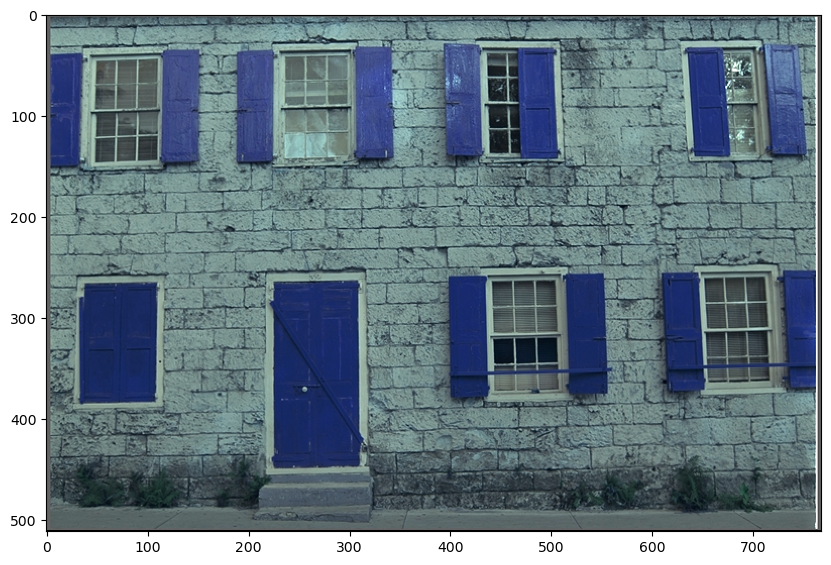

In [31]:
image = cv2.imread("kodim01.png")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig1 = py.figure(figsize = (10,10))
#imagelue = py.imread('RGB.jpg')
#image=imagelue.astype('double')
#py.imshow(imagelue)
py.imshow(image)

py.show()

Calcul des valeurs moyennes des RGB. Nécessaire pour calculer la matrice de covariance des RGB

In [32]:
sommeR = 0.0
sommeG = 0.0
sommeB = 0.0
for i in range(len(image)):
    for j in range(len(image[0])):
        sommeR=sommeR+image[i][j][0]
        sommeG=sommeG+image[i][j][1]
        sommeB=sommeB+image[i][j][2]

nbPixels = len(image)*len(image[0])
MoyR= sommeR / nbPixels
MoyG= sommeG / nbPixels
MoyB= sommeB / nbPixels

print(MoyR)
print(MoyG)
print(MoyB)

88.38654073079427
108.74630991617839
119.76126098632812


Calcul de la matrice de covariance des RGB

In [33]:
covRGB = np.zeros((3,3), dtype = "double")
for i in range(len(image)):
    for j in range(len(image[0])):
        vecTemp=[[image[i][j][0] - MoyR], [image[i][j][1]] - MoyG, [image[i][j][2] - MoyB]]
        vecProdTemp = np.dot(vecTemp,np.transpose(vecTemp))
        covRGB = np.add(covRGB,vecProdTemp)

covRGB = covRGB / nbPixels
print(covRGB)

[[1609.11051465 1778.77308749 1163.60137659]
 [1778.77308749 2000.75071754 1332.56502175]
 [1163.60137659 1332.56502175 1192.50270116]]


Calcul des vecteurs propres et valeurs propres

In [34]:
eigval, eigvec = LA.eig(covRGB)
print(eigval)
print()
print(eigvec)

[4531.6136244    13.7390913   257.01121765]

[[-0.5879143  -0.71792965 -0.37273824]
 [-0.65969535  0.69219138 -0.29269975]
 [-0.46814403 -0.07381131  0.88056406]]


Pour illustrer les bénéfices du changement de repère, une composante sur trois sera supprimée dans le nouveau repère. a=Mb, où b est la composant RGB - la moyenne, M la matrice de transformation de repère, et a est la composante dans l'espace des vecteurs propres.

In [35]:
eigvec = np.transpose(eigvec)
eigvecsansAxe0 = np.copy(eigvec)
eigvecsansAxe0[0,:] = [0.0,0.0,0.0]
eigvecsansAxe1 = np.copy(eigvec)
eigvecsansAxe1[1,:] = [0.0,0.0,0.0]
eigvecsansAxe2 = np.copy(eigvec)
eigvecsansAxe2[2,:] = [0.0,0.0,0.0]

imageKLsansAxe0 = np.copy(image)
imageKLsansAxe1 = np.copy(image)
imageKLsansAxe2 = np.copy(image)

vecMoy =[[MoyR], [MoyG], [MoyB]]

for i in range(len(image)):
    for j in range(len(image[0])):
        vecTemp=[[image[i][j][0]], [image[i][j][1]], [image[i][j][2]]]
        #a=Mb
        imageKLsansAxe0[i][j][:] = np.reshape(np.dot(eigvecsansAxe0,np.subtract(vecTemp,vecMoy)),(3))
        imageKLsansAxe1[i][j][:] = np.reshape(np.dot(eigvecsansAxe1,np.subtract(vecTemp,vecMoy)),(3))
        imageKLsansAxe2[i][j][:] = np.reshape(np.dot(eigvecsansAxe2,np.subtract(vecTemp,vecMoy)),(3))



Les images dans les repères définis par les vecteurs propres ne peuvent pas être affichées. Toutefois, en éliminant un axe, on a retiré 33% de l'information. Une composante vaut zéro. Exemple:

In [36]:
print(imageKLsansAxe0[10][10][:])

[  0   4 253]


En faisant la transformée inverse, on peut voir les images qui résultent de la compression. b=inv(M)a. Dans le code, on utilse pinv (Pseudo-inverse), car la matrice est parfois singulière. Il faut faire b + moyenne.

In [37]:
invEigvecsansAxe0 = LA.pinv(eigvecsansAxe0);
invEigvecsansAxe1 = LA.pinv(eigvecsansAxe1);
invEigvecsansAxe2 = LA.pinv(eigvecsansAxe2);

vecMoy =[MoyR, MoyG, MoyB]
imageRGBsansAxe0 = np.copy(image)
imageRGBsansAxe1 = np.copy(image)
imageRGBsansAxe2 = np.copy(image)

for i in range(len(image)):
    for j in range(len(image[0])):
        #b=inv(M)a
        vecTempsansAxe0=[[imageKLsansAxe0[i][j][0]], [imageKLsansAxe0[i][j][1]], [imageKLsansAxe0[i][j][2]]]
        vecTempsansAxe1=[[imageKLsansAxe1[i][j][0]], [imageKLsansAxe1[i][j][1]], [imageKLsansAxe1[i][j][2]]]
        vecTempsansAxe2=[[imageKLsansAxe2[i][j][0]], [imageKLsansAxe2[i][j][1]], [imageKLsansAxe2[i][j][2]]]
        imageRGBsansAxe0[i][j][:] = np.add(np.reshape(np.dot(invEigvecsansAxe0,vecTempsansAxe0),(3)),vecMoy)
        imageRGBsansAxe1[i][j][:] = np.add(np.reshape(np.dot(invEigvecsansAxe1,vecTempsansAxe1),(3)),vecMoy)
        imageRGBsansAxe2[i][j][:] = np.add(np.reshape(np.dot(invEigvecsansAxe2,vecTempsansAxe2),(3)),vecMoy)

Résultat sans l'axe de plus grande énergie. L'image est très dégradée.

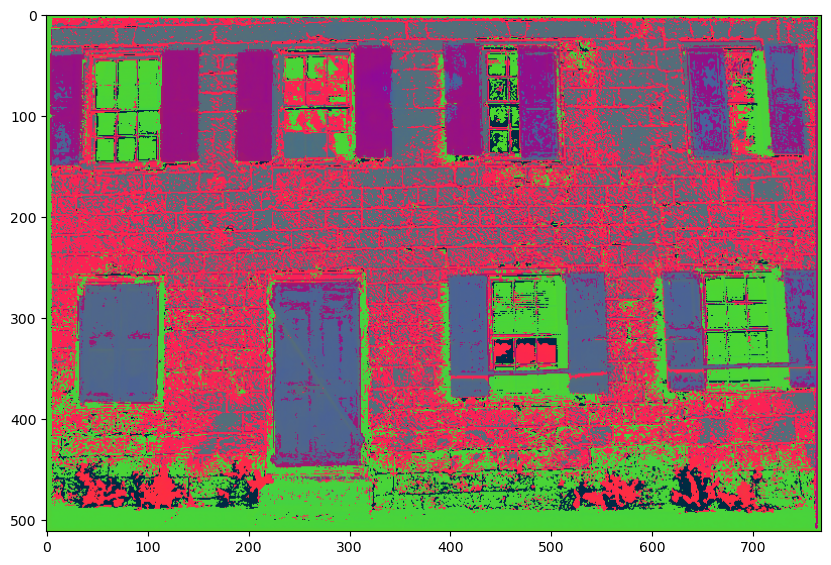

In [38]:
fig2 = py.figure(figsize = (10,10))
imageout = np.clip(imageRGBsansAxe0,0,255)
imageout= imageout.astype('uint8')
py.imshow(imageout)
py.show()

Résultat sans l'axe de moyenne énergie. L'image assez dégradée.

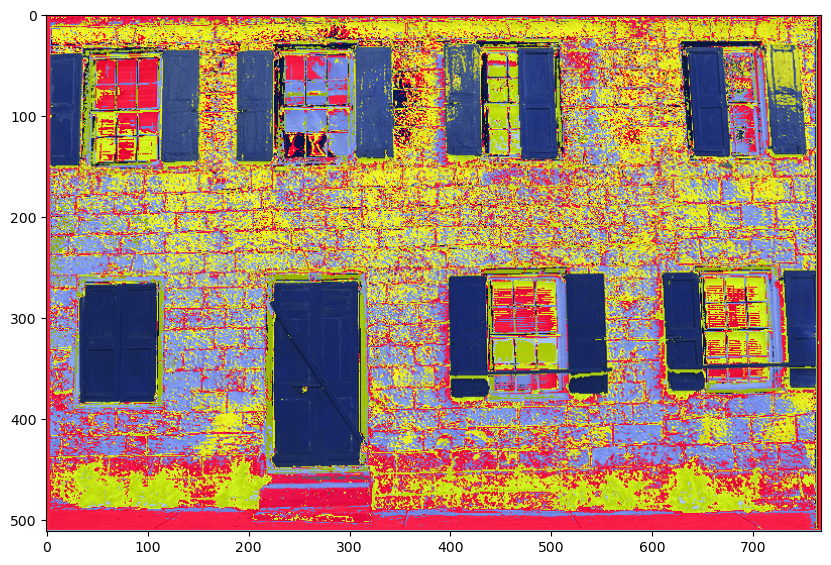

In [39]:
fig2 = py.figure(figsize = (10,10))
imageout = np.clip(imageRGBsansAxe1,0,255)
imageout= imageout.astype('uint8')
py.imshow(imageout)
py.show()

Résultat sans l'axe de faible énergie. L'impact sur l'image est minime.

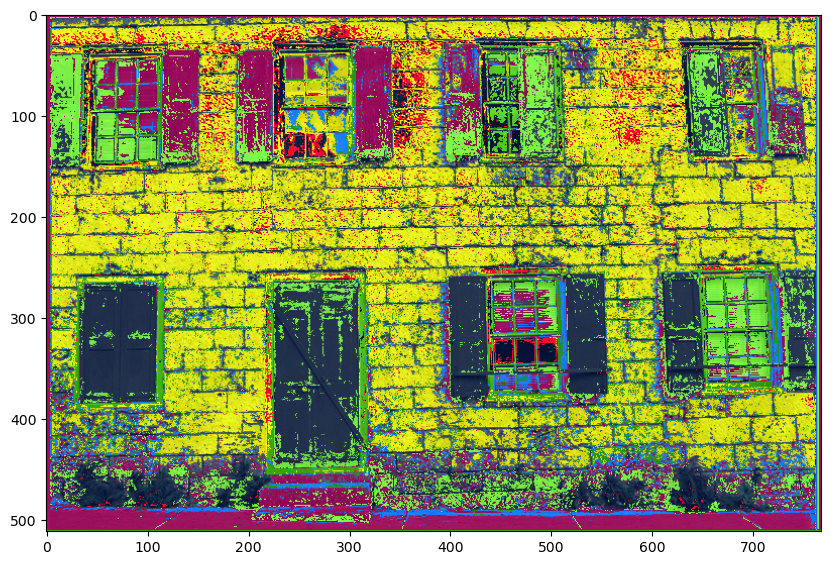

In [40]:
fig2 = py.figure(figsize = (10,10))
imageout = np.clip(imageRGBsansAxe2,0,255)
imageout= imageout.astype('uint8')
py.imshow(imageout)
py.show()